In [1]:
%matplotlib notebook

import numpy as np
import json
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from numpy.random import seed 
seed(2)
tf.random.set_seed(9)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU,Dense, Dropout, Flatten, Input, BatchNormalization, Reshape, UpSampling1D, Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import regularizers

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,Binarizer

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
fp_list = ['maccs']

class Data():
    
    def __init__(self, fp, pos_neg):
        
        self.fp = fp
        self.pos_neg = pos_neg
        
        if self.pos_neg == 'pos':
            self.load_pos_data()
            self.shuffle()
            
        elif self.pos_neg == 'neg':
            self.load_neg_data()
            self.shuffle()
    

    def load_pos_data(self):
        with open('{}.json'.format(self.fp), 'r') as file:
            temp = json.load(file)
        positive_index = [i for i in range(len(temp['y'])) if temp['y'][i] == [1,0]]
        self.y = np.array([temp['y'][i] for i in positive_index])
        self.x = np.array([self.convert(temp['x'][i]) for i in positive_index])
        self.x = self.x.reshape(self.x.shape[0], self.x.shape[1],1)
        self.z = self.x.reshape(self.x.shape[0], self.x.shape[1])
        self.m = len(positive_index)
        self.n = self.x.shape[1]
        print('Shape x: {}'.format(self.x.shape))
        print('Shape y: {}'.format(self.y.shape))
    
    def load_neg_data(self):
        with open('{}.json'.format(self.fp), 'r') as file:
            temp = json.load(file)
        negative_index = [i for i in range(len(temp['y'])) if temp['y'][i] == [0,1]]
        self.y = np.array([temp['y'][i] for i in negative_index])
        self.x = np.array([self.convert(temp['x'][i]) for i in negative_index])
        self.x = self.x.reshape(self.x.shape[0], self.x.shape[1],1)
        self.z = self.x.reshape(self.x.shape[0], self.x.shape[1])
        self.m = len(negative_index)
        self.n = self.x.shape[1]
        print('Shape x: {}'.format(self.x.shape))
        print('Shape y: {}'.format(self.y.shape))
    
    def shuffle(self):
        temp_x = np.zeros(self.x.shape)
        index = list(range(self.m))
        np.random.shuffle(index)
        for x in range(self.m):
            value = int(index[int(x)])
            temp_x[x,:] = self.x[value,:]
        self.x = temp_x
                                  
    def convert(self, string, as_array=True):
        letter_list = list('abcdef')
        jump = 1
        fp = []
        code = [0]*len(list(string))*4
        for index in range(len(list(string))):
            index += jump
            value = string[index].lower()
            if value in letter_list:
                value = letter_list.index(value) + 10
            index = (index-jump)*4
            value = int(value)
            code[index] = 1*value%2
            code[index+1] = 1*math.floor(value/2)%2
            code[index+2] = 1*math.floor(value/4)%2
            code[index+3] = 1*math.floor(value/8)%2
            jump *= -1
        if as_array == True:
            code = np.array(code)
        return code

In [3]:
pos_data=Data(fp='maccs', pos_neg='pos')
neg_data=Data(fp='maccs', pos_neg='neg')

Shape x: (7201, 168, 1)
Shape y: (7201, 2)
Shape x: (10000, 168, 1)
Shape y: (10000, 2)


In [4]:
batch_size=256
fingerprint_dim=168

#get real compounds
index = np.random.choice(range(pos_data.m), size=(batch_size), replace=False)
train_x_real = pos_data.x[index]
train_y_real = np.zeros([batch_size,2])
train_y_real[:,0] = 1
#d_loss_real = d.train_on_batch(train_x_real,train_y_real)
                
#get fake compounds
input_value = np.random.randint(0,2,size=[batch_size, fingerprint_dim])
train_x_fake = input_value.reshape((input_value.shape[0], input_value.shape[1], 1))
train_y_fake = np.zeros([batch_size,2])
train_y_fake[:,1] = 1
#d_loss_fake=d.train_on_batch(train_x_fake,train_y_fake)
        
#get decoys
index1 = np.random.choice(range(neg_data.m), size=(batch_size), replace=False)
train_x_decoy = neg_data.x[index1]
train_y_decoy = np.zeros([batch_size,2])
train_y_decoy[:,1] = 1
#d_loss_decoy = d.train_on_batch(train_x_real,train_y_real)
       
# d_loss = d_loss_real + d_loss_decoy
# loss_d_epoch.append(d_loss[0])
X = np.concatenate((train_x_real, train_x_decoy))
y = np.zeros([2*batch_size,2])
y[0:(batch_size),0] = 1
y[(batch_size):,1] = 1

In [6]:
epochs=1

model = Sequential()
model.add(Conv1D(64, kernel_size=11,
                 strides=4,
                 activation='relu',
                 padding='valid',
                 input_shape=[fingerprint_dim,1],
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='valid'))
model.add(Conv1D(128, kernel_size=5, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='valid'))

model.add(Conv1D(256, kernel_size=3, activation= 'relu', strides=1, padding='same'))
model.add(Conv1D(256, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv1D(128, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0002),
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            768       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 128)           41088     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 256)            98560     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 9, 256)            196864    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 9, 128)            9

In [7]:
model.fit(X, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X, y))

2/2 [==============================] - 0s 150ms/step - loss: 18.0149 - accuracy: 0.5293 - val_loss: 17.7829 - val_accuracy: 0.5137


In [8]:
cv = StratifiedKFold(n_splits=10)

In [9]:
df_y = pd.DataFrame(y)

In [10]:
y_new = df_y.iloc[:,0]

In [12]:
mean_fpr = np.linspace(0, 1, 100)
tprs=[]
tprs_all=[]
fprs=[]
aucs=[]
accs=[]
f1s=[]
for train,test in cv.split(X,y_new):
    model.fit(X[train],y[train],
             batch_size=batch_size,
             epochs=50,
             verbose=1,
             validation_data=(X[test],y[test]))
    pred_prob = model.predict_proba(X[test])[:,0]
    pred = model.predict(X[test])[:,0]
    y_pred = np.round(pred)
    print(y_pred)
    print(pred_prob)
    fpr, tpr, thresholds = roc_curve(y_new[test],pred_prob)
    roc_auc = auc(fpr,tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_all.append(interp_tpr)
    
    acc = accuracy_score(y_new[test], y_pred)
    f1 = f1_score(y_new[test], y_pred)
    accs.append(acc)
    f1s.append(f1)
    
    

Epoch 1/50
2/2 [==============================] - 0s 133ms/step - loss: 17.7143 - accuracy: 0.5543 - val_loss: 17.4767 - val_accuracy: 0.5192
Epoch 2/50
2/2 [==============================] - 0s 33ms/step - loss: 17.4093 - accuracy: 0.5783 - val_loss: 17.1743 - val_accuracy: 0.5385
Epoch 3/50
2/2 [==============================] - 0s 37ms/step - loss: 17.1078 - accuracy: 0.5696 - val_loss: 16.8761 - val_accuracy: 0.5577
Epoch 4/50
2/2 [==============================] - 0s 33ms/step - loss: 16.8098 - accuracy: 0.5804 - val_loss: 16.5821 - val_accuracy: 0.5385
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 16.5165 - accuracy: 0.5674 - val_loss: 16.2922 - val_accuracy: 0.5192
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 16.2276 - accuracy: 0.5478 - val_loss: 16.0065 - val_accuracy: 0.5192
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 15.9421 - accuracy: 0.5696 - val_loss: 15.7249 - val_accuracy: 0.5385
Epoch 8/50
2

2/2 [==============================] - 0s 35ms/step - loss: 6.9793 - accuracy: 0.8391 - val_loss: 6.7613 - val_accuracy: 0.8654
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 6.8441 - accuracy: 0.8370 - val_loss: 6.6684 - val_accuracy: 0.8462
Epoch 4/50
2/2 [==============================] - 0s 27ms/step - loss: 6.7200 - accuracy: 0.8304 - val_loss: 6.5258 - val_accuracy: 0.8654
Epoch 5/50
2/2 [==============================] - 0s 26ms/step - loss: 6.5991 - accuracy: 0.8370 - val_loss: 6.4140 - val_accuracy: 0.8846
Epoch 6/50
2/2 [==============================] - 0s 31ms/step - loss: 6.4890 - accuracy: 0.8370 - val_loss: 6.3097 - val_accuracy: 0.8654
Epoch 7/50
2/2 [==============================] - 0s 26ms/step - loss: 6.3599 - accuracy: 0.8370 - val_loss: 6.1952 - val_accuracy: 0.9038
Epoch 8/50
2/2 [==============================] - 0s 30ms/step - loss: 6.2407 - accuracy: 0.8587 - val_loss: 6.0840 - val_accuracy: 0.8846
Epoch 9/50
2/2 [======================

2/2 [==============================] - 0s 27ms/step - loss: 2.6710 - accuracy: 0.9935 - val_loss: 2.6074 - val_accuracy: 1.0000
Epoch 5/50
2/2 [==============================] - 0s 26ms/step - loss: 2.6148 - accuracy: 0.9935 - val_loss: 2.5704 - val_accuracy: 1.0000
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 2.5619 - accuracy: 0.9978 - val_loss: 2.5325 - val_accuracy: 0.9804
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 2.5229 - accuracy: 0.9957 - val_loss: 2.4851 - val_accuracy: 1.0000
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 2.4716 - accuracy: 1.0000 - val_loss: 2.4425 - val_accuracy: 1.0000
Epoch 9/50
2/2 [==============================] - 0s 26ms/step - loss: 2.4329 - accuracy: 0.9957 - val_loss: 2.3973 - val_accuracy: 1.0000
Epoch 10/50
2/2 [==============================] - 0s 27ms/step - loss: 2.3872 - accuracy: 0.9978 - val_loss: 2.3558 - val_accuracy: 1.0000
Epoch 11/50
2/2 [====================

2/2 [==============================] - 0s 27ms/step - loss: 1.1097 - accuracy: 1.0000 - val_loss: 1.0930 - val_accuracy: 1.0000
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0931 - accuracy: 0.9978 - val_loss: 1.0835 - val_accuracy: 1.0000
Epoch 9/50
2/2 [==============================] - 0s 26ms/step - loss: 1.0752 - accuracy: 1.0000 - val_loss: 1.0607 - val_accuracy: 1.0000
Epoch 10/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0602 - accuracy: 1.0000 - val_loss: 1.0514 - val_accuracy: 1.0000
Epoch 11/50
2/2 [==============================] - 0s 30ms/step - loss: 1.0424 - accuracy: 1.0000 - val_loss: 1.0331 - val_accuracy: 1.0000
Epoch 12/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0275 - accuracy: 1.0000 - val_loss: 1.0166 - val_accuracy: 1.0000
Epoch 13/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0125 - accuracy: 1.0000 - val_loss: 1.0108 - val_accuracy: 1.0000
Epoch 14/50
2/2 [=================

2/2 [==============================] - 0s 27ms/step - loss: 0.5648 - accuracy: 1.0000 - val_loss: 0.5595 - val_accuracy: 1.0000
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.5591 - accuracy: 1.0000 - val_loss: 0.5509 - val_accuracy: 1.0000
Epoch 11/50
2/2 [==============================] - 0s 29ms/step - loss: 0.5508 - accuracy: 1.0000 - val_loss: 0.5459 - val_accuracy: 1.0000
Epoch 12/50
2/2 [==============================] - 0s 28ms/step - loss: 0.5455 - accuracy: 1.0000 - val_loss: 0.5413 - val_accuracy: 1.0000
Epoch 13/50
2/2 [==============================] - 0s 28ms/step - loss: 0.5404 - accuracy: 1.0000 - val_loss: 0.5349 - val_accuracy: 1.0000
Epoch 14/50
2/2 [==============================] - 0s 27ms/step - loss: 0.5339 - accuracy: 1.0000 - val_loss: 0.5301 - val_accuracy: 1.0000
Epoch 15/50
2/2 [==============================] - 0s 27ms/step - loss: 0.5292 - accuracy: 1.0000 - val_loss: 0.5286 - val_accuracy: 1.0000
Epoch 16/50
2/2 [===============

2/2 [==============================] - 0s 26ms/step - loss: 0.3594 - accuracy: 1.0000 - val_loss: 0.3599 - val_accuracy: 1.0000
Epoch 13/50
2/2 [==============================] - 0s 27ms/step - loss: 0.3564 - accuracy: 1.0000 - val_loss: 0.3583 - val_accuracy: 1.0000
Epoch 14/50
2/2 [==============================] - 0s 27ms/step - loss: 0.3547 - accuracy: 1.0000 - val_loss: 0.3560 - val_accuracy: 1.0000
Epoch 15/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3539 - accuracy: 1.0000 - val_loss: 0.3540 - val_accuracy: 1.0000
Epoch 16/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3510 - accuracy: 1.0000 - val_loss: 0.3527 - val_accuracy: 1.0000
Epoch 17/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3487 - accuracy: 1.0000 - val_loss: 0.3505 - val_accuracy: 1.0000
Epoch 18/50
2/2 [==============================] - 0s 27ms/step - loss: 0.3467 - accuracy: 1.0000 - val_loss: 0.3490 - val_accuracy: 1.0000
Epoch 19/50
2/2 [===============

2/2 [==============================] - 0s 27ms/step - loss: 0.2796 - accuracy: 1.0000 - val_loss: 0.2799 - val_accuracy: 1.0000
Epoch 15/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2801 - accuracy: 1.0000 - val_loss: 0.2785 - val_accuracy: 1.0000
Epoch 16/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2779 - accuracy: 1.0000 - val_loss: 0.2769 - val_accuracy: 1.0000
Epoch 17/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2777 - accuracy: 1.0000 - val_loss: 0.2762 - val_accuracy: 1.0000
Epoch 18/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2751 - accuracy: 1.0000 - val_loss: 0.2755 - val_accuracy: 1.0000
Epoch 19/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2744 - accuracy: 1.0000 - val_loss: 0.2743 - val_accuracy: 1.0000
Epoch 20/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2735 - accuracy: 1.0000 - val_loss: 0.2732 - val_accuracy: 1.0000
Epoch 21/50
2/2 [===============

2/2 [==============================] - 0s 28ms/step - loss: 0.2376 - accuracy: 1.0000 - val_loss: 0.2363 - val_accuracy: 1.0000
Epoch 18/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2360 - accuracy: 1.0000 - val_loss: 0.2356 - val_accuracy: 1.0000
Epoch 19/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2359 - accuracy: 1.0000 - val_loss: 0.2349 - val_accuracy: 1.0000
Epoch 20/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2343 - accuracy: 1.0000 - val_loss: 0.2351 - val_accuracy: 1.0000
Epoch 21/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2346 - accuracy: 1.0000 - val_loss: 0.2341 - val_accuracy: 1.0000
Epoch 22/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2338 - accuracy: 1.0000 - val_loss: 0.2342 - val_accuracy: 1.0000
Epoch 23/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2325 - accuracy: 1.0000 - val_loss: 0.2333 - val_accuracy: 1.0000
Epoch 24/50
2/2 [===============

2/2 [==============================] - 0s 26ms/step - loss: 0.2115 - accuracy: 1.0000 - val_loss: 0.2202 - val_accuracy: 1.0000
Epoch 20/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2106 - accuracy: 1.0000 - val_loss: 0.2162 - val_accuracy: 1.0000
Epoch 21/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2106 - accuracy: 1.0000 - val_loss: 0.2176 - val_accuracy: 1.0000
Epoch 22/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2107 - accuracy: 1.0000 - val_loss: 0.2141 - val_accuracy: 1.0000
Epoch 23/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2088 - accuracy: 1.0000 - val_loss: 0.2143 - val_accuracy: 1.0000
Epoch 24/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2086 - accuracy: 1.0000 - val_loss: 0.2174 - val_accuracy: 1.0000
Epoch 25/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2082 - accuracy: 1.0000 - val_loss: 0.2152 - val_accuracy: 1.0000
Epoch 26/50
2/2 [===============

2/2 [==============================] - 0s 28ms/step - loss: 0.1926 - accuracy: 1.0000 - val_loss: 0.1956 - val_accuracy: 1.0000
Epoch 22/50
2/2 [==============================] - 0s 26ms/step - loss: 0.1925 - accuracy: 1.0000 - val_loss: 0.1961 - val_accuracy: 1.0000
Epoch 23/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1929 - accuracy: 1.0000 - val_loss: 0.1952 - val_accuracy: 1.0000
Epoch 24/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1921 - accuracy: 1.0000 - val_loss: 0.1946 - val_accuracy: 1.0000
Epoch 25/50
2/2 [==============================] - 0s 26ms/step - loss: 0.1912 - accuracy: 1.0000 - val_loss: 0.1952 - val_accuracy: 1.0000
Epoch 26/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1901 - accuracy: 1.0000 - val_loss: 0.1967 - val_accuracy: 1.0000
Epoch 27/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1909 - accuracy: 1.0000 - val_loss: 0.1964 - val_accuracy: 1.0000
Epoch 28/50
2/2 [===============

<IPython.core.display.Javascript object>


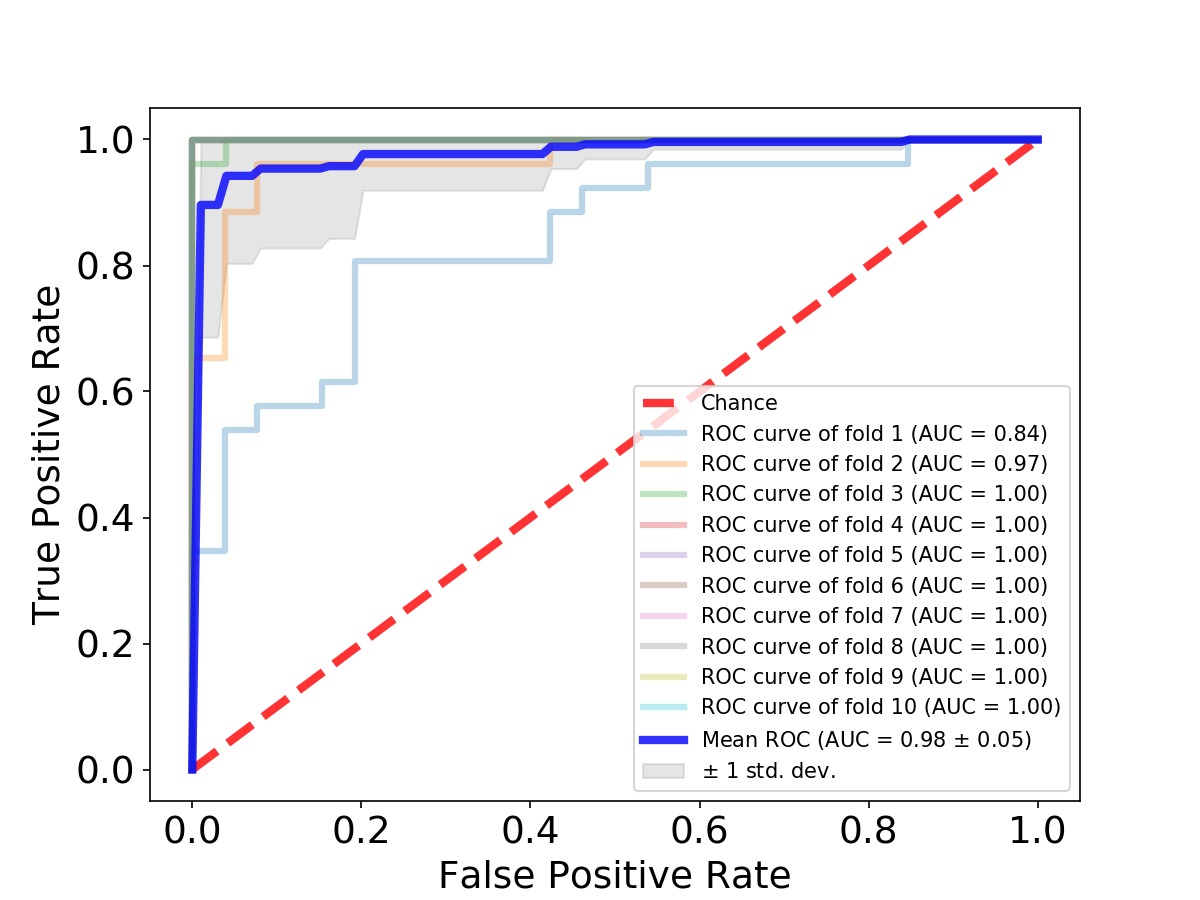

In [13]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot([0, 1], [0, 1], linestyle='--', color='r',
        label='Chance', alpha=.8, linewidth = 4)

for j in range(10):
    ax.plot(fprs[j], tprs[j], label='ROC curve of fold {0} (AUC = {1:0.2f})'.format(j+1, aucs[j]), alpha=0.3, linewidth = 3)

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs_all, axis=0)
mean_tpr[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr)
std_auc_svm = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svm, std_auc_svm),
        alpha=.8, linewidth = 4)

std_tpr = np.std(tprs_all, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])

ax.legend(loc="lower right")

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={"size":10})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('maccs_D_alexnet.pdf',dpi=600)
plt.show()